In [104]:
import numpy as np
from scipy.sparse import csr_matrix
import scipy.sparse.linalg
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [105]:
def updateWLRAgrad_with_momentum(
    X,
    W,
    v,
    u,
    step=None,
    reg_lambda=0.1,
    momentum=0.9,
    velocity=None,
):
    """
    Updates a single factor matrix (u) while keeping the other (v) fixed.
    Includes L2 regularization and acceleration momentum.
    """
    R = u.dot(v.T) - X  # Residual matrix
    WR = W.multiply(R)  # Masked residual
    gradu = WR.dot(v) + reg_lambda * u  # Gradient with L2 regularization

    # Initialize velocity if not provided
    if velocity is None or len(velocity) == 0:
        velocity = np.zeros_like(u)

    # Update velocity and apply momentum
    velocity = momentum * velocity - step * gradu
    unew = u + velocity  # Update u using momentum-based velocity
    e1 = np.sum((W.multiply(X - unew.dot(v.T))).power(2)) + reg_lambda * np.sum(unew**2)
    u = unew
    return u, step, e1, velocity

In [106]:
# Load data matrix
data = loadmat('Data/matlab/inputX.mat')  # Load the .mat file
X = data['X']  # Assuming the matrix is stored under the key 'X'
X = csr_matrix(X)  # Convert to sparse matrix
m, n = X.shape
numX = X.count_nonzero()

# Construct binary weight matrix
W = X.copy()
W.data = np.ones_like(W.data)

rank = 7


u, _, v = scipy.sparse.linalg.svds(X, k=rank)
v = v.T

Iteration 1, RMSE: 3.75009723578231
Iteration 2, RMSE: 3.749480153460772
Iteration 3, RMSE: 3.7481844006797047
Iteration 4, RMSE: 3.74552290412049
Iteration 5, RMSE: 3.7400242018171084
Iteration 6, RMSE: 3.7285596543893353
Iteration 7, RMSE: 3.7045442277446976
Iteration 8, RMSE: 3.6544652766205803
Iteration 9, RMSE: 3.5522519611530003
Iteration 10, RMSE: 3.354907252753882
Iteration 11, RMSE: 3.0205740139971433
Iteration 12, RMSE: 2.6048242147568925
Iteration 13, RMSE: 2.360334656214742
Iteration 14, RMSE: 2.310167344729087
Iteration 15, RMSE: 2.0913294701761678
Iteration 16, RMSE: 1.7854891600371776
Iteration 17, RMSE: 1.7220310277421893
Iteration 18, RMSE: 1.791399495114874
Iteration 19, RMSE: 1.7653061730418376
Iteration 20, RMSE: 1.674058912912959
Iteration 21, RMSE: 1.6254186820061285
Iteration 22, RMSE: 1.5915213520550144
Iteration 23, RMSE: 1.516926408871456
Iteration 24, RMSE: 1.44010206783975
Iteration 25, RMSE: 1.3977018627388333
Iteration 26, RMSE: 1.3667418022592346
Iteratio

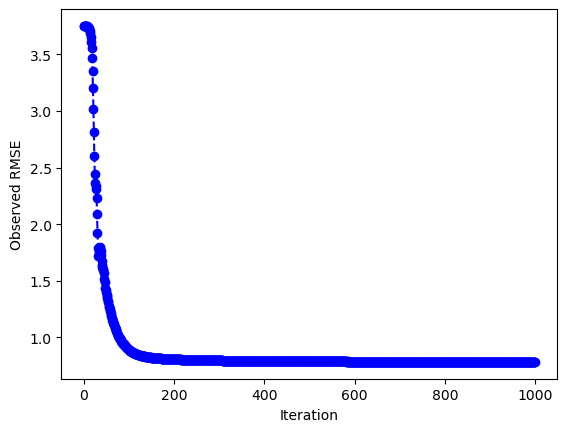

In [107]:
# Estimate the parameters of the model: Optimize u and v alternatively via gradient descent
k = 1
max_k = 500
uprec = u
stepu = 1e-4
stepv = 1e-4
velocity_u = []
velocity_v = []
e = []

while k <= max_k:  # Stopping criterion
    # Update u
    u, stepu, eu, velocity_u = updateWLRAgrad_with_momentum(
        X, W, v, u, step=stepu, velocity=velocity_u
    )
    # Update v
    v, stepv, ev, velocity_v = updateWLRAgrad_with_momentum(
        X.T, W.T, u, v, stepv, velocity=velocity_v
    )
    e.extend([np.sqrt(eu / numX), np.sqrt(ev / numX)])
    print(f"Iteration {k}, RMSE: {e[-1]}")
    k += 1

# Display the evolution of the RMSE
plt.figure()
plt.xlabel("Iteration")
plt.ylabel("Observed RMSE")
plt.plot(e, "bo--")
plt.show()

In [108]:
# Construct the prediction in a csv file
data_eval = loadmat('Data/matlab/inputEval.mat')
Eval = data_eval['Eval']
numpred = Eval.shape[0]
predic = np.zeros((numpred,2))
# predic[:,0] = np.linspace(1, numpred, numpred, endpoint=True).round().astype(int)
for i in range(numpred):
    predic[i,0] = int(i + 1)
    predic[i,1] = np.dot(u[Eval[i,0]-1], v[Eval[i,1]-1])
    # Make sure the prediction is in [1,5]
    predic[i,1] = max(1, predic[i,1])
    predic[i,1] = min(5, predic[i,1])
np.savetxt('svd_accelerated.csv', predic, delimiter=',', fmt=["%d"] + ["%.4f"], header="ID,Rating",comments='')